In [48]:
import csv
import collections

import numpy as np
import matplotlib.pyplot as plt

In [61]:
def read_data(filename):
    times = []   # sec
    flows = []   # L/sec
    with open(filename) as file:
        start_fill = False
        for line in csv.reader(file):
            if start_fill:
                times.append(float(line[1].replace(",", "")))
                flows.append(np.sign(float(line[2]))*abs(float(line[2]) / 0.0538)**(4.0/7.0) / 60.0)
            if line[0] == "Sample #":
                start_fill = True
    return collections.namedtuple("Data", ["times", "flows"])(np.array(times), np.array(flows))

first = read_data("../sample-data/Sensirion_Philippe.csv")
normal = read_data("../sample-data/Sensirion_Philippe_normal.csv")
strong = read_data("../sample-data/Sensirion_Philippe_strongl.csv")

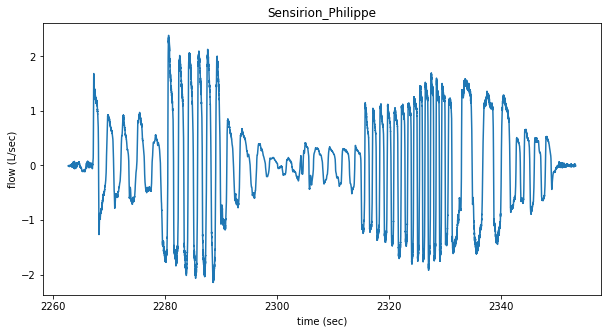

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(first.times, first.flows)
ax.set_title("Sensirion_Philippe")
ax.set_xlabel("time (sec)")
ax.set_ylabel("flow (L/sec)")
fig.savefig("Sensirion_Philippe.png")

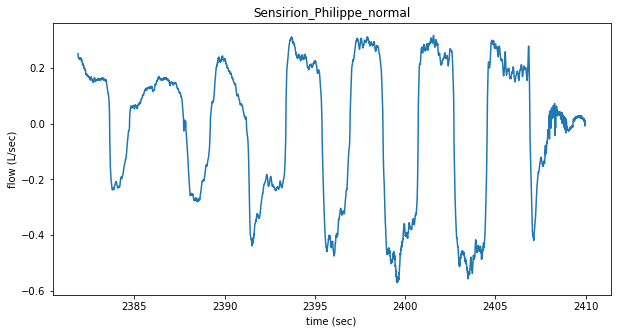

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(normal.times, normal.flows)
ax.set_title("Sensirion_Philippe_normal")
ax.set_xlabel("time (sec)")
ax.set_ylabel("flow (L/sec)")
fig.savefig("Sensirion_Philippe_normal.png")

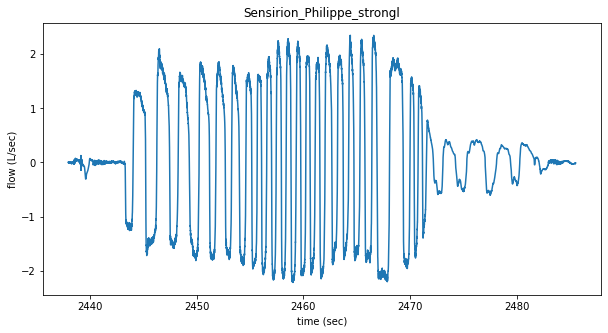

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(strong.times, strong.flows)
ax.set_title("Sensirion_Philippe_strongl")
ax.set_xlabel("time (sec)")
ax.set_ylabel("flow (L/sec)")
fig.savefig("Sensirion_Philippe_strongl.png")